### Import libraries

In [4]:
import torch
import warnings
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from time import time
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from fvcore.nn import FlopCountAnalysis, flop_count_table
from datasets.cityscapes import CityScapes
from utils import fast_hist, per_class_iou
from models.deeplabv2.deeplabv2 import get_deeplab_v2

# Ignore warnings
warnings.filterwarnings("ignore")

### Training

In [5]:
# Define the polynomial learning rate scheduler
def poly_lr_scheduler(optimizer, init_lr, iter, lr_decay_iter=1, max_iter=300, power=0.9):
    lr = init_lr * (1 - iter / max_iter) ** power
    optimizer.param_groups[0]['lr'] = lr
    return lr

# Set the device
device = torch.device('cuda')

# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2').to(device)
# Set the model to training mode
model.train()

# Set the loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='train')
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, num_workers=4)

# Train the model
for epoch in range(50):
    # Initialize the hist matrix at each epoch
    hist = np.zeros((19, 19))
    for image, label in tqdm(dataloader):
        image = image.to(device)
        label = label.to(device)
        # Forward pass
        output = model(image)[0]
        # Calculate the loss
        loss = criterion(output, label)
        # Zero the gradients
        optimizer.zero_grad()
        # Backward pass
        loss.backward()
        # Update the weights
        optimizer.step()
        # Compute the predictions
        pred = output.argmax(dim=1)
        # Calculate the mean IoU
        hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
        miou = np.mean(per_class_iou(hist))

    # Update the learning rate
    poly_lr_scheduler(optimizer, 0.001, epoch, max_iter=len(dataloader))

    # Print the loss and mIoU
    print(f'Epoch: {epoch}, Loss: {loss.item()}, mIoU: {miou}')

# Save the model
torch.save(model.state_dict(), 'models/deeplabv2/deeplabv2_step2a/deeplabv2.pth')

Deeplab pretraining loading...


100%|██████████| 786/786 [05:16<00:00,  2.49it/s]


Epoch: 0, Loss: 0.2063758671283722, mIoU: 0.3805389146843618


100%|██████████| 786/786 [05:01<00:00,  2.61it/s]


Epoch: 1, Loss: 0.2018134891986847, mIoU: 0.5495569927578275


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 2, Loss: 0.21311384439468384, mIoU: 0.6140366430852418


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 3, Loss: 0.2973240911960602, mIoU: 0.6458333580412419


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 4, Loss: 0.1825062781572342, mIoU: 0.6661856154724832


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 5, Loss: 0.16446274518966675, mIoU: 0.684258496045201


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 6, Loss: 0.20018571615219116, mIoU: 0.6966829526090802


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 7, Loss: 0.21300280094146729, mIoU: 0.7081043676097183


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 8, Loss: 0.10568564385175705, mIoU: 0.7158386784728074


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 9, Loss: 0.11287789046764374, mIoU: 0.7224122871829693


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 10, Loss: 0.12107192724943161, mIoU: 0.725061076968547


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 11, Loss: 0.1012253612279892, mIoU: 0.7352304630111787


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 12, Loss: 0.1212562769651413, mIoU: 0.7402940280459989


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 13, Loss: 0.143440380692482, mIoU: 0.7448467311666168


100%|██████████| 786/786 [05:05<00:00,  2.58it/s]


Epoch: 14, Loss: 0.14513452351093292, mIoU: 0.7480132808409397


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 15, Loss: 0.12651851773262024, mIoU: 0.7519843683239712


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 16, Loss: 0.11760683357715607, mIoU: 0.7562882647196243


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 17, Loss: 0.17710274457931519, mIoU: 0.7594879717092943


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 18, Loss: 0.10512206703424454, mIoU: 0.7632771931868794


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 19, Loss: 0.16999578475952148, mIoU: 0.7645851350495274


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 20, Loss: 0.1401827037334442, mIoU: 0.7692217183877734


100%|██████████| 786/786 [05:05<00:00,  2.58it/s]


Epoch: 21, Loss: 0.14944559335708618, mIoU: 0.7718155683321567


100%|██████████| 786/786 [05:04<00:00,  2.58it/s]


Epoch: 22, Loss: 0.17882204055786133, mIoU: 0.7738803228077167


100%|██████████| 786/786 [05:05<00:00,  2.58it/s]


Epoch: 23, Loss: 0.10406665503978729, mIoU: 0.7762623423360236


100%|██████████| 786/786 [05:07<00:00,  2.56it/s]


Epoch: 24, Loss: 0.15465112030506134, mIoU: 0.7781586101529796


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 25, Loss: 0.1117447167634964, mIoU: 0.7793966365546137


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 26, Loss: 0.1278432458639145, mIoU: 0.782130356856381


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 27, Loss: 0.10245610028505325, mIoU: 0.7838590142978813


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 28, Loss: 0.11997895687818527, mIoU: 0.7862304210763027


100%|██████████| 786/786 [05:06<00:00,  2.57it/s]


Epoch: 29, Loss: 0.1588646024465561, mIoU: 0.7875570017482454


100%|██████████| 786/786 [05:07<00:00,  2.56it/s]


Epoch: 30, Loss: 0.06956764310598373, mIoU: 0.789562223435866


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 31, Loss: 0.09535229206085205, mIoU: 0.7914852625778712


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 32, Loss: 0.1406514197587967, mIoU: 0.7926129320493684


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 33, Loss: 0.07492487877607346, mIoU: 0.7930507051773423


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 34, Loss: 0.12624402344226837, mIoU: 0.7951036203486408


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 35, Loss: 0.10754399746656418, mIoU: 0.7970055432627365


100%|██████████| 786/786 [05:07<00:00,  2.56it/s]


Epoch: 36, Loss: 0.09229008853435516, mIoU: 0.7978605701078438


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 37, Loss: 0.11652876436710358, mIoU: 0.7995290189199087


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 38, Loss: 0.10248754918575287, mIoU: 0.8009883923070903


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 39, Loss: 0.10034912824630737, mIoU: 0.8014149640691439


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 40, Loss: 0.0894288495182991, mIoU: 0.8031528258006356


100%|██████████| 786/786 [05:07<00:00,  2.56it/s]


Epoch: 41, Loss: 0.10222522169351578, mIoU: 0.8041429188396232


100%|██████████| 786/786 [05:07<00:00,  2.56it/s]


Epoch: 42, Loss: 0.15790843963623047, mIoU: 0.8053161807494094


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 43, Loss: 0.11918115615844727, mIoU: 0.806498369670496


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 44, Loss: 0.10367756336927414, mIoU: 0.807253918229938


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 45, Loss: 0.1101074367761612, mIoU: 0.8086341703454799


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 46, Loss: 0.10228317230939865, mIoU: 0.8097300102366218


100%|██████████| 786/786 [05:06<00:00,  2.56it/s]


Epoch: 47, Loss: 0.07648869603872299, mIoU: 0.8105034774206603


100%|██████████| 786/786 [05:06<00:00,  2.57it/s]


Epoch: 48, Loss: 0.09644290804862976, mIoU: 0.8114559842032442


100%|██████████| 786/786 [05:05<00:00,  2.57it/s]


Epoch: 49, Loss: 0.11072459071874619, mIoU: 0.8119986912060697


### Validation

In [6]:
# Set the device
device = torch.device('cuda')

# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2').to(device)
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2_step2a/deeplabv2.pth'))
# Set the model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

# Validate the model
# Initialize the hist matrix
hist = np.zeros((19, 19))
for i, (image, label) in tqdm(enumerate(dataloader)):
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Calculate the mean IoU
    hist += fast_hist(label.flatten().cpu().numpy(), pred.flatten().cpu().numpy(), 19)
    miou = np.mean(per_class_iou(hist))
    
# Print the mIoU
print(f'mIoU: {miou}')

Deeplab pretraining loading...


500it [00:32, 15.28it/s]

mIoU: 0.6004147910250586


### Example

Deeplab pretraining loading...


0it [00:00, ?it/s]


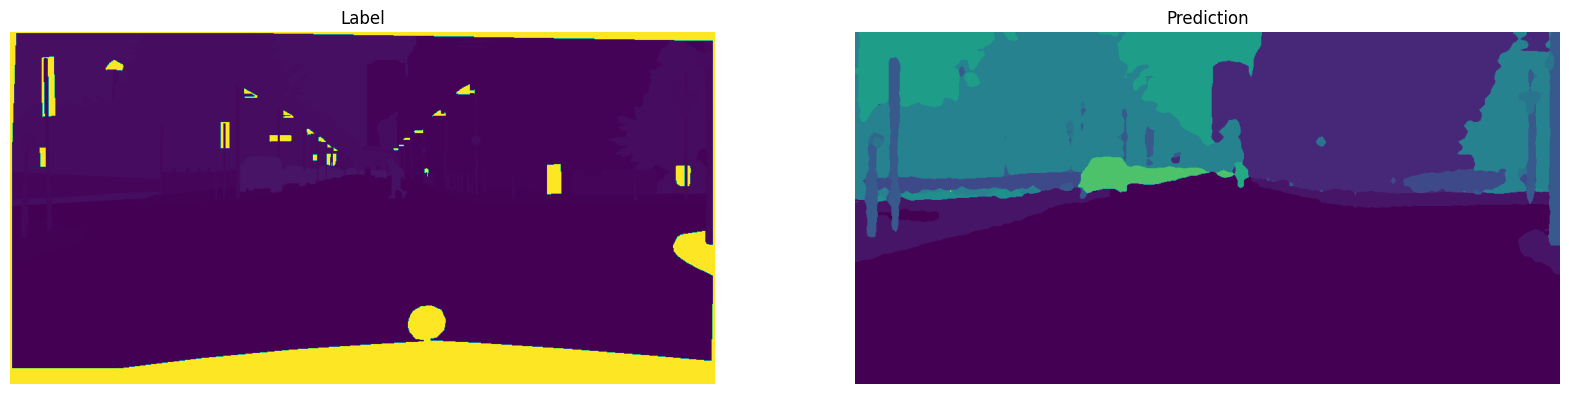

In [7]:
# Set the device
device = torch.device('cuda')

# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2').to(device)
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2_step2a/deeplabv2.pth'))
# Set the model to evaluation mode
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

# Validate the model
# Initialize the hist matrix
hist = np.zeros((19, 19))
for i, (image, label) in tqdm(enumerate(dataloader)):
    image = image.to(device)
    label = label.to(device)
    # Forward pass
    output = model(image)
    # Compute the predictions
    pred = output.argmax(dim=1)
    # Break after the first iteration
    break

# Display the image
image = ToPILImage()(image[0].cpu())
# Convert label, pred from numpy to image
label = Image.fromarray(label[0].cpu().numpy().astype(np.uint8))
pred = Image.fromarray(pred[0].cpu().numpy().astype(np.uint8))

# Display the image
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(label)
plt.title('Label')
plt.axis('off')
plt.subplot(122)
plt.imshow(pred)
plt.title('Prediction')
plt.axis('off')
plt.show()

### FLOPs and Parameters

In [8]:
# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2')
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2_step2a/deeplabv2.pth'))
model.eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
# Get the image and label
image, label = dataset[0]

# Compute the number of flops
flops = FlopCountAnalysis(model, image.unsqueeze(0))
# Get the number of flops
flops = flop_count_table(flops)
# Get the number of parameters
params = sum(p.numel() for p in model.parameters())

# Print the number of parameters and flops
print(f'Number of parameters: {params}\n')
print(flops)

Deeplab pretraining loading...
Number of parameters: 43901068

| module                         | #parameters or shape   | #flops     |
|:-------------------------------|:-----------------------|:-----------|
| model                          | 43.901M                | 0.375T     |
|  conv1                         |  9.408K                |  1.233G    |
|   conv1.weight                 |   (64, 3, 7, 7)        |            |
|  bn1                           |  0.128K                |  16.777M   |
|   bn1.weight                   |   (64,)                |            |
|   bn1.bias                     |   (64,)                |            |
|  layer1                        |  0.216M                |  7.155G    |
|   layer1.0                     |   75.008K              |   2.487G   |
|    layer1.0.conv1              |    4.096K              |    0.136G  |
|    layer1.0.bn1                |    0.128K              |    4.244M  |
|    layer1.0.conv2              |    36.864K             |  

### Latency and FPS

In [9]:
# Set the device
device = torch.device('cuda')   

# Load the model
model = get_deeplab_v2(root_dir='models/deeplabv2')
model.load_state_dict(torch.load('models/deeplabv2/deeplabv2_step2a/deeplabv2.pth'))
model.to(device).eval()

# Load the dataset
dataset = CityScapes(root_dir='datasets/Cityspaces', split='val')
# Get the image and label
image, label = dataset[0]

# Compute the latency and FPS
iterations = 1000
latency = []
fps = []

# Compute the latency and FPS
for _ in range(iterations):
    start = time()
    model(image.unsqueeze(0).to(device))
    end = time()
    latency.append(end - start)
    fps.append(1 / (end - start))

# Compute the average latency and FPS
mean_latency = np.mean(latency)
mean_fps = np.mean(fps)
std_latency = np.std(latency)
std_fps = np.std(fps)

# Print the latency and FPS
print(f'Latency: {mean_latency:.3f} +/- {std_latency:.3f}')
print(f'FPS: {mean_fps:.3f} +/- {std_fps:.3f}')

Deeplab pretraining loading...
Latency: 0.058 +/- 0.002
FPS: 17.319 +/- 4.183
